In [64]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot

In [99]:
def rmse(predictions, targets):

    differences = predictions - targets                       

    differences_squared = differences ** 2                    

    mean_of_differences_squared = differences_squared.mean()  

    rmse_val = np.sqrt(mean_of_differences_squared)           

    return rmse_val            

# Importar o arquivo

In [34]:
df = pd.read_csv('micro.txt', sep = ';')

In [35]:
df.head()

,NU_ANO,CO_IES,CO_CATEGAD,CO_ORGACAD,CO_GRUPO,CO_CURSO,CO_MODALIDADE,CO_MUNIC_CURSO,CO_UF_CURSO,CO_REGIAO_CURSO,...,QE_I72,QE_I73,QE_I74,QE_I75,QE_I76,QE_I77,QE_I78,QE_I79,QE_I80,QE_I81
0,2014,1,10002,10028,5710,3,1,5103403,51,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,1,10002,10028,5710,3,1,5103403,51,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,1,10002,10028,5710,3,1,5103403,51,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,1,10002,10028,5710,3,1,5103403,51,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,1,10002,10028,5710,3,1,5103403,51,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Prep

In [36]:
#Remover as colunas de percepção da prova - impossível saber isso antes da realização da prova
colunas = ['CO_RS_I1',
 'CO_RS_I2',
 'CO_RS_I3',
 'CO_RS_I4',
 'CO_RS_I5',
 'CO_RS_I6',
 'CO_RS_I7',
 'CO_RS_I8',
 'CO_RS_I9']

data_filtrada = df.drop(columns = colunas)

In [37]:
#Remover colunas de quantidade de perguntas e itens excluídos
colunas2 = ['NU_ITEM_OFG',
 'NU_ITEM_OFG_Z',
 'NU_ITEM_OFG_X',
 'NU_ITEM_OFG_N',
 'NU_ITEM_OCE',
 'NU_ITEM_OCE_Z',
 'NU_ITEM_OCE_X',
 'NU_ITEM_OCE_N']

data_filtrada = data_filtrada.drop(columns = colunas2)

In [38]:
#Remover colunas de perguntas de percepção específicas para licenciatura
colunas3 = ['QE_I69',
 'QE_I70',
 'QE_I71',
 'QE_I72',
 'QE_I73',
 'QE_I74',
 'QE_I75',
 'QE_I76',
 'QE_I77',
 'QE_I78',
 'QE_I79',
 'QE_I80',
 'QE_I81']

data_filtrada = data_filtrada.drop(columns = colunas3)

In [39]:
#Remover colunas de respostas das perguntas
colunas4 = ['DS_VT_GAB_OFG_ORIG',
 'DS_VT_GAB_OFG_FIN',
 'DS_VT_GAB_OCE_ORIG',
 'DS_VT_GAB_OCE_FIN',
 'DS_VT_ESC_OFG',
 'DS_VT_ACE_OFG',
 'DS_VT_ESC_OCE',
 'DS_VT_ACE_OCE']

data_filtrada = data_filtrada.drop(columns = colunas4)

In [41]:
#Remover colunas com apenas 1 tipo de resposta - não agregam ao modelo
colunas5 = []
for i in data_filtrada.columns:
  if len(data_filtrada[i].unique().tolist()) == 1:
    colunas5.append(i)

data_filtrada = data_filtrada.drop(columns = colunas5)

In [42]:
#Remover colunas de notas parciais - queremos prever apenas a nota geral final
colunas6 = ['NT_FG',
 'NT_OBJ_FG',
 'NT_DIS_FG',
 'NT_FG_D1',
 'NT_FG_D1_PT',
 'NT_FG_D1_CT',
 'NT_FG_D2',
 'NT_FG_D2_PT',
 'NT_FG_D2_CT',
 'NT_CE',
 'NT_OBJ_CE',
 'NT_DIS_CE',
 'NT_CE_D1',
 'NT_CE_D2',
 'NT_CE_D3']

data_filtrada = data_filtrada.drop(columns = colunas6)

In [43]:
###Colunas de percepção do curso e participação do curso no desenvolvimento pessoal
var = []
res = []
for x in data_filtrada.columns.tolist()[54:]:
  temp = data_filtrada.groupby(x).size().tolist()
  temp2 = (temp[0]+temp[5])/sum(temp)   #As respostas na posição 0 ou 5 são as válidas
  var.append(x)
  res.append(temp2)
 
tabela1 = pd.DataFrame({'Variavel':var, 'Perc_Respostas_Validas':res})
del temp,temp2,var,res
tabela1

,Variavel,Perc_Respostas_Validas
0,QE_I27,0.581320
1,QE_I28,0.556993
2,QE_I29,0.544824
3,QE_I30,0.549739
4,QE_I31,0.627763
5,QE_I32,0.632480
6,QE_I33,0.653740
7,QE_I34,0.622961
8,QE_I35,0.615541
9,QE_I36,0.567821


In [44]:
###Temos um alto número de respostas inválidas nessas categorias. Vamos dropar as colunas para não prejudicar a análise
colunas7 = ['QE_I27',
 'QE_I28',
 'QE_I29',
 'QE_I30',
 'QE_I31',
 'QE_I32',
 'QE_I33',
 'QE_I34',
 'QE_I35',
 'QE_I36',
 'QE_I37',
 'QE_I38',
 'QE_I39',
 'QE_I40',
 'QE_I41',
 'QE_I42',
 'QE_I43',
 'QE_I44',
 'QE_I45',
 'QE_I46',
 'QE_I47',
 'QE_I48',
 'QE_I49',
 'QE_I50',
 'QE_I51',
 'QE_I52',
 'QE_I53',
 'QE_I54',
 'QE_I55',
 'QE_I56',
 'QE_I57',
 'QE_I58',
 'QE_I59',
 'QE_I60',
 'QE_I61',
 'QE_I62',
 'QE_I63',
 'QE_I64',
 'QE_I65',
 'QE_I66',
 'QE_I67',
 'QE_I68']

data_filtrada = data_filtrada.drop(columns = colunas7)


In [45]:
###Vamos pegar apenas os alunos com notas válidas ( classificados como 555 nas colunas de TIPO DE PRESENÇA E TIPO DE SITUAÇÃO DAS QUESTÕES)
data_filtrada = data_filtrada.loc[(data_filtrada.TP_PRES == 555) 
                  & (data_filtrada.TP_PR_GER == 555) 
                  & (data_filtrada.TP_PR_OB_FG == 555) 
                  & (data_filtrada.TP_PR_DI_FG == 555)
                  & (data_filtrada.TP_PR_OB_CE == 555)
                  & (data_filtrada.TP_PR_DI_CE == 555)
                  & (data_filtrada.TP_SFG_D1 == 555)
                  & (data_filtrada.TP_SFG_D2 == 555)
                  & (data_filtrada.TP_SCE_D1 == 555)
                  & (data_filtrada.TP_SCE_D2 == 555)
                  & (data_filtrada.TP_SCE_D3 == 555)]

In [46]:
###Dropar as colunas que mostram o status da presença dos alunos nas provas, pois já pegamos apenas os alunos válidos
colunas8 = ['TP_PRES',
 'TP_PR_GER',
 'TP_PR_OB_FG',
 'TP_PR_DI_FG',
 'TP_PR_OB_CE',
 'TP_PR_DI_CE',
 'TP_SFG_D1',
 'TP_SFG_D2',
 'TP_SCE_D1',
 'TP_SCE_D2',
 'TP_SCE_D3']

data_filtrada = data_filtrada.drop(columns = colunas8)

In [47]:
####Dropar CO_CURSO --- obtemos a informação em alto nível com CO_GRUPO que tem menor cardinalidade

data_filtrada = data_filtrada.drop(columns = ['CO_CURSO'])

In [48]:
###Renomear colunas de perguntas

data_filtrada.rename(columns = {'QE_I01'   : 'ESTADO_CIVIL' 
,'QE_I02'  : 'ORIGEM_RACIAL' 
,'QE_I03'  : 'NACIONALIDADE' 
,'QE_I04'  : 'ESCOLARIDADE_PAI' 
,'QE_I05'  : 'ESCOLARIDADE_MAE' 
,'QE_I06'  : 'TIPO_MORADIA' 
,'QE_I07'  : 'QTD_PESSOAS_MORADIA' 
,'QE_I08'  : 'RENDA' 
,'QE_I09'  : 'SITUACAO_FINANCEIRA' 
,'QE_I10'  : 'SITUACAO_TRABALHO' 
,'QE_I11'  : 'BOLSA_FINANCIAMENTO' 
,'QE_I12'  : 'AUXILIO_PERMANENCIA' 
,'QE_I13'  : 'BOLSA_ACADEMICA' 
,'QE_I14'  : 'ESTUDO_EXTERIOR' 
,'QE_I15'  : 'COTAS' 
,'QE_I16'  : 'ESTADO_ENSINO_MEDIO' 
,'QE_I17'  : 'TIPO_ESCOLA_ENSINO_MEDIO' 
,'QE_I18'  : 'MODALIDADE_ENSINO_MEDIO' 
,'QE_I19'  : 'INCENTIVO_GRADUACAO' 
,'QE_I20'  : 'DIFICULDADES_GRADUACAO' 
,'QE_I21'  : 'FAMILIAR_COM_CURSO_SUPERIOR' 
,'QE_I22'  : 'LEITURA_LIVROS' 
,'QE_I23'  : 'HORAS_ESTUDO' 
,'QE_I24'  : 'IDIOMA_ESTRANGEIRO' 
,'QE_I25'  : 'MOTIVACAO_CURSO' 
,'QE_I26'  : 'MOTIVACAO_IES' 
    
}, inplace = True)

In [57]:
###Cardinalidade das variáveis
temp = []
temp2 = []
temp3 = pd.DataFrame
for i in data_filtrada.columns:
  temp.append(i)
  temp2.append(len(data_filtrada[i].unique().tolist()))
temp3({'Variavel':temp, 'Cardinalidade':temp2}).sort_values('Cardinalidade', ascending = False)
del temp,temp2,temp3

In [59]:
#checar missings

missing = []
missing2 = []
for i in data_filtrada.columns:
    missing.append(i)
    missing2.append(str(100*sum(data_filtrada[i].isna())/data_filtrada.shape[0]))

table_missing = pd.DataFrame({'Variavel':missing,
                             '%Missings':missing2}).sort_values('%Missings', ascending = False)
print(table_missing)
del missing,missing2, table_missing

                       Variavel             %Missings
41                MOTIVACAO_IES    0.2900475094053555
40              MOTIVACAO_CURSO    0.2900475094053555
39           IDIOMA_ESTRANGEIRO    0.2900475094053555
28              BOLSA_ACADEMICA    0.2876932276731692
31          ESTADO_ENSINO_MEDIO    0.2876932276731692
33      MODALIDADE_ENSINO_MEDIO   0.28722237132673195
29              ESTUDO_EXTERIOR   0.28722237132673195
30                        COTAS   0.28722237132673195
32     TIPO_ESCOLA_ENSINO_MEDIO   0.28722237132673195
34          INCENTIVO_GRADUACAO   0.28722237132673195
35       DIFICULDADES_GRADUACAO   0.28722237132673195
36  FAMILIAR_COM_CURSO_SUPERIOR   0.28722237132673195
37               LEITURA_LIVROS   0.28722237132673195
38                 HORAS_ESTUDO   0.28722237132673195
22          QTD_PESSOAS_MORADIA   0.28251380786235925
27          AUXILIO_PERMANENCIA   0.28251380786235925
26          BOLSA_FINANCIAMENTO   0.28251380786235925
25            SITUACAO_TRABA

In [60]:
###Preencher missings com moda p/ variaveis categoricas ou mediana para numericas
for i in data_filtrada.columns:
  if (sum(data_filtrada[i].isnull()) != 0 and data_filtrada[i].dtypes == 'object'):
    data_filtrada[i] = data_filtrada[i].fillna(data_filtrada[i].mode()[0])  
  elif ( sum(data_filtrada[i].isnull()) != 0 and data_filtrada[i].dtypes == 'float64'):
     data_filtrada[i] = data_filtrada[i].fillna(data_filtrada[i].median())  

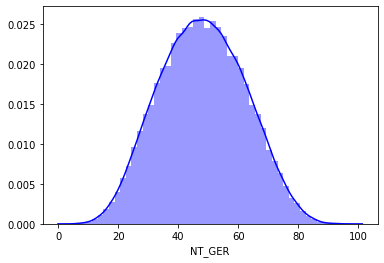

In [22]:
#Distribuição das Notas
sns.distplot(data_filtrada.NT_GER, kde=True, color="blue")

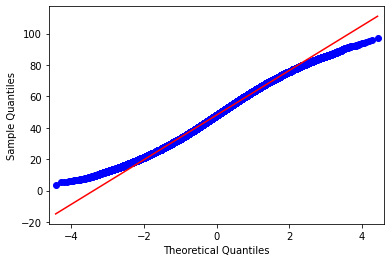

In [65]:
###QQPLOT
qqplot(data_filtrada.NT_GER, line='s')
pyplot.show()

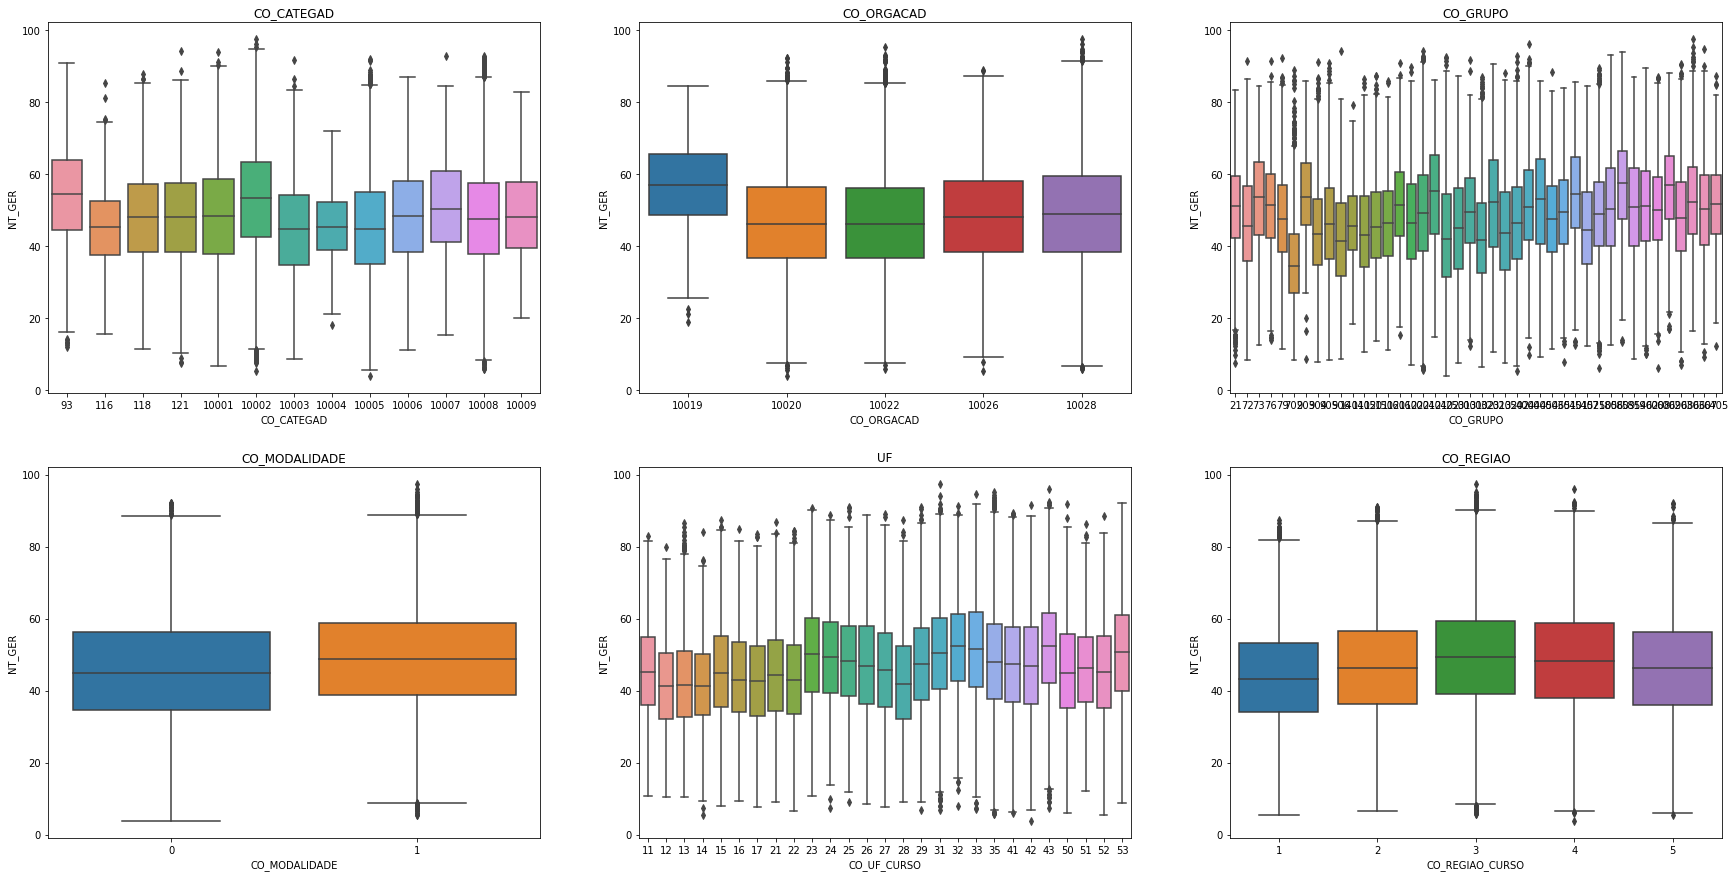

In [68]:
###Distribuição das notas
f, axs = plt.subplots(2,3,figsize=(30,15))
plt.subplot(231)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.CO_CATEGAD)
plt.title('CO_CATEGAD')
plt.subplot(232)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.CO_ORGACAD)
plt.title('CO_ORGACAD')
plt.subplot(233)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.CO_GRUPO)
plt.title('CO_GRUPO')
plt.subplot(234)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.CO_MODALIDADE)
plt.title('CO_MODALIDADE')
plt.subplot(235)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.CO_UF_CURSO)
plt.title('UF')
plt.subplot(236)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.CO_REGIAO_CURSO)
plt.title('CO_REGIAO')
plt.show()

In [69]:
#Agrupar variavel em tecnologo ou nao tecnologo
data_filtrada.CO_ORGACAD = np.where(data_filtrada.CO_ORGACAD == 10019, 'Tecnologo', 'Nao Tecnologo')

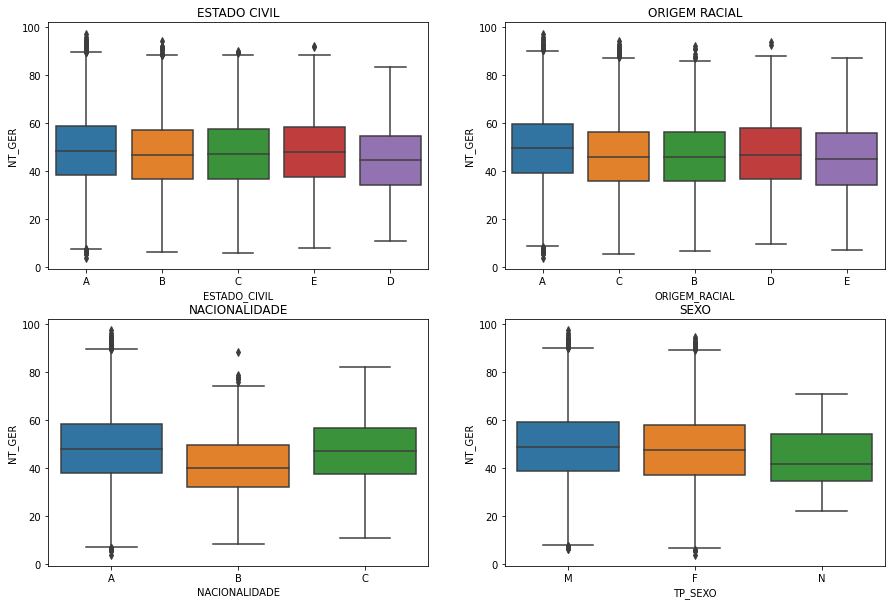

In [73]:
###Distribuição das notas
f, axs = plt.subplots(2,2,figsize=(15,10))
plt.subplot(221)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.ESTADO_CIVIL)
plt.title('ESTADO CIVIL')
plt.subplot(222)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.ORIGEM_RACIAL)
plt.title('ORIGEM RACIAL')
plt.subplot(223)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.NACIONALIDADE)
plt.title('NACIONALIDADE')
plt.subplot(224)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.TP_SEXO)
plt.title('SEXO')
plt.show()

In [74]:
#Agrupar Estado Civil
data_filtrada.ESTADO_CIVIL = np.where(data_filtrada.ESTADO_CIVIL == 'D', 'Viuvo', 'Nao Viuvo')

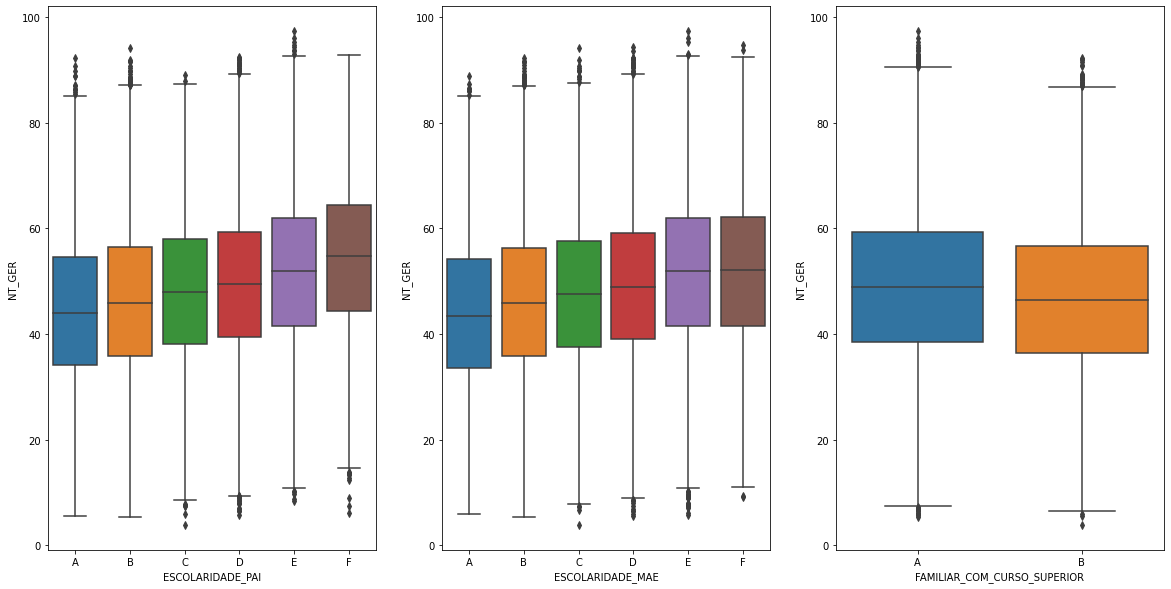

In [76]:
###Distribuição das notas
f, axs = plt.subplots(1,3,figsize=(20,10))
plt.subplot(131)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.ESCOLARIDADE_PAI,order = ['A','B','C','D','E', 'F'])
plt.subplot(132)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.ESCOLARIDADE_MAE,order = ['A','B','C','D','E', 'F'])
plt.subplot(133)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.FAMILIAR_COM_CURSO_SUPERIOR, order= ['A','B'])
plt.show()

In [77]:
###Deixar escolaridade como ordinal
data_filtrada.ESCOLARIDADE_PAI = data_filtrada.ESCOLARIDADE_PAI.replace({'A':0,
'B':1,
'C':2,
'D':3,
'E':4,
'F':5
})

data_filtrada.ESCOLARIDADE_MAE = data_filtrada.ESCOLARIDADE_MAE.replace({'A':0,
'B':1,
'C':2,
'D':3,
'E':4,
'F':5
})

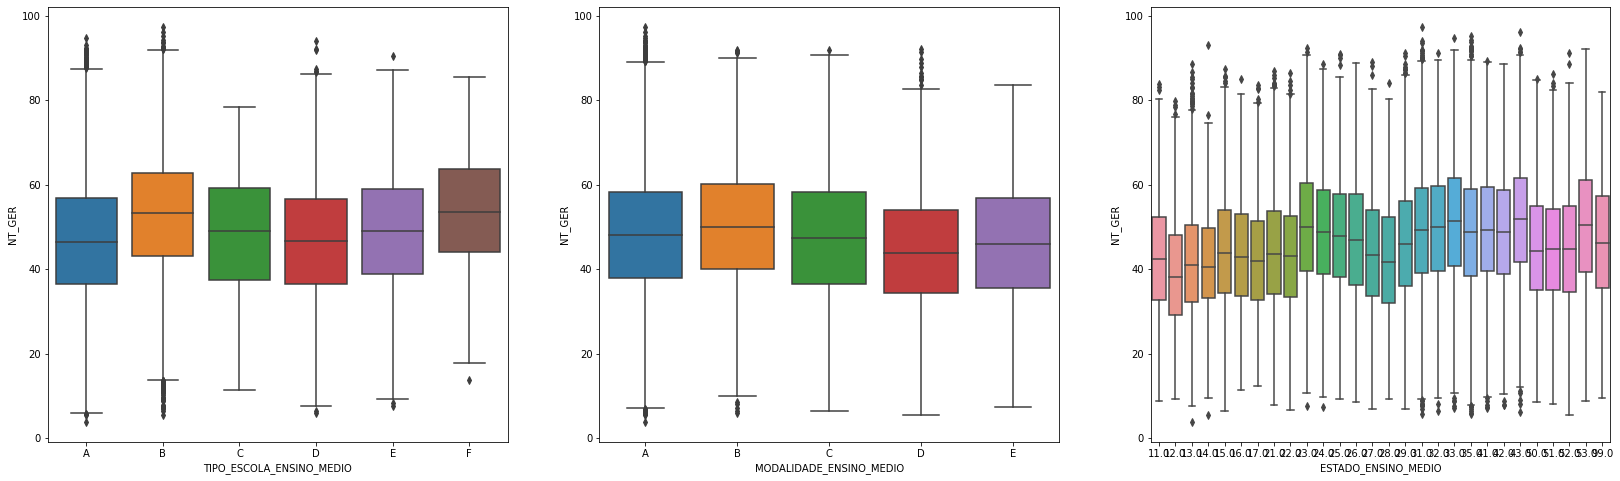

In [78]:
###Distribuição das notas
f, axs = plt.subplots(1,3,figsize=(28,8))
plt.subplot(131)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.TIPO_ESCOLA_ENSINO_MEDIO,order = ['A','B','C','D','E', 'F'])
plt.subplot(132)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.MODALIDADE_ENSINO_MEDIO)
plt.subplot(133)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.ESTADO_ENSINO_MEDIO)

In [79]:
#Agrupar ensino medio em publico e particular
data_filtrada.TIPO_ESCOLA_ENSINO_MEDIO = np.where(data_filtrada.TIPO_ESCOLA_ENSINO_MEDIO == 'D', 'Publico', data_filtrada.TIPO_ESCOLA_ENSINO_MEDIO)
data_filtrada.TIPO_ESCOLA_ENSINO_MEDIO = np.where(data_filtrada.TIPO_ESCOLA_ENSINO_MEDIO == 'A', 'Publico', data_filtrada.TIPO_ESCOLA_ENSINO_MEDIO)
data_filtrada.TIPO_ESCOLA_ENSINO_MEDIO = np.where(data_filtrada.TIPO_ESCOLA_ENSINO_MEDIO == 'B', 'Particular', data_filtrada.TIPO_ESCOLA_ENSINO_MEDIO)
data_filtrada.TIPO_ESCOLA_ENSINO_MEDIO = np.where(data_filtrada.TIPO_ESCOLA_ENSINO_MEDIO == 'E', 'Particular', data_filtrada.TIPO_ESCOLA_ENSINO_MEDIO)
data_filtrada.TIPO_ESCOLA_ENSINO_MEDIO = np.where(data_filtrada.TIPO_ESCOLA_ENSINO_MEDIO == 'F', 'Particular', data_filtrada.TIPO_ESCOLA_ENSINO_MEDIO)
data_filtrada.TIPO_ESCOLA_ENSINO_MEDIO = np.where(data_filtrada.TIPO_ESCOLA_ENSINO_MEDIO == 'C', 'Particular', data_filtrada.TIPO_ESCOLA_ENSINO_MEDIO)

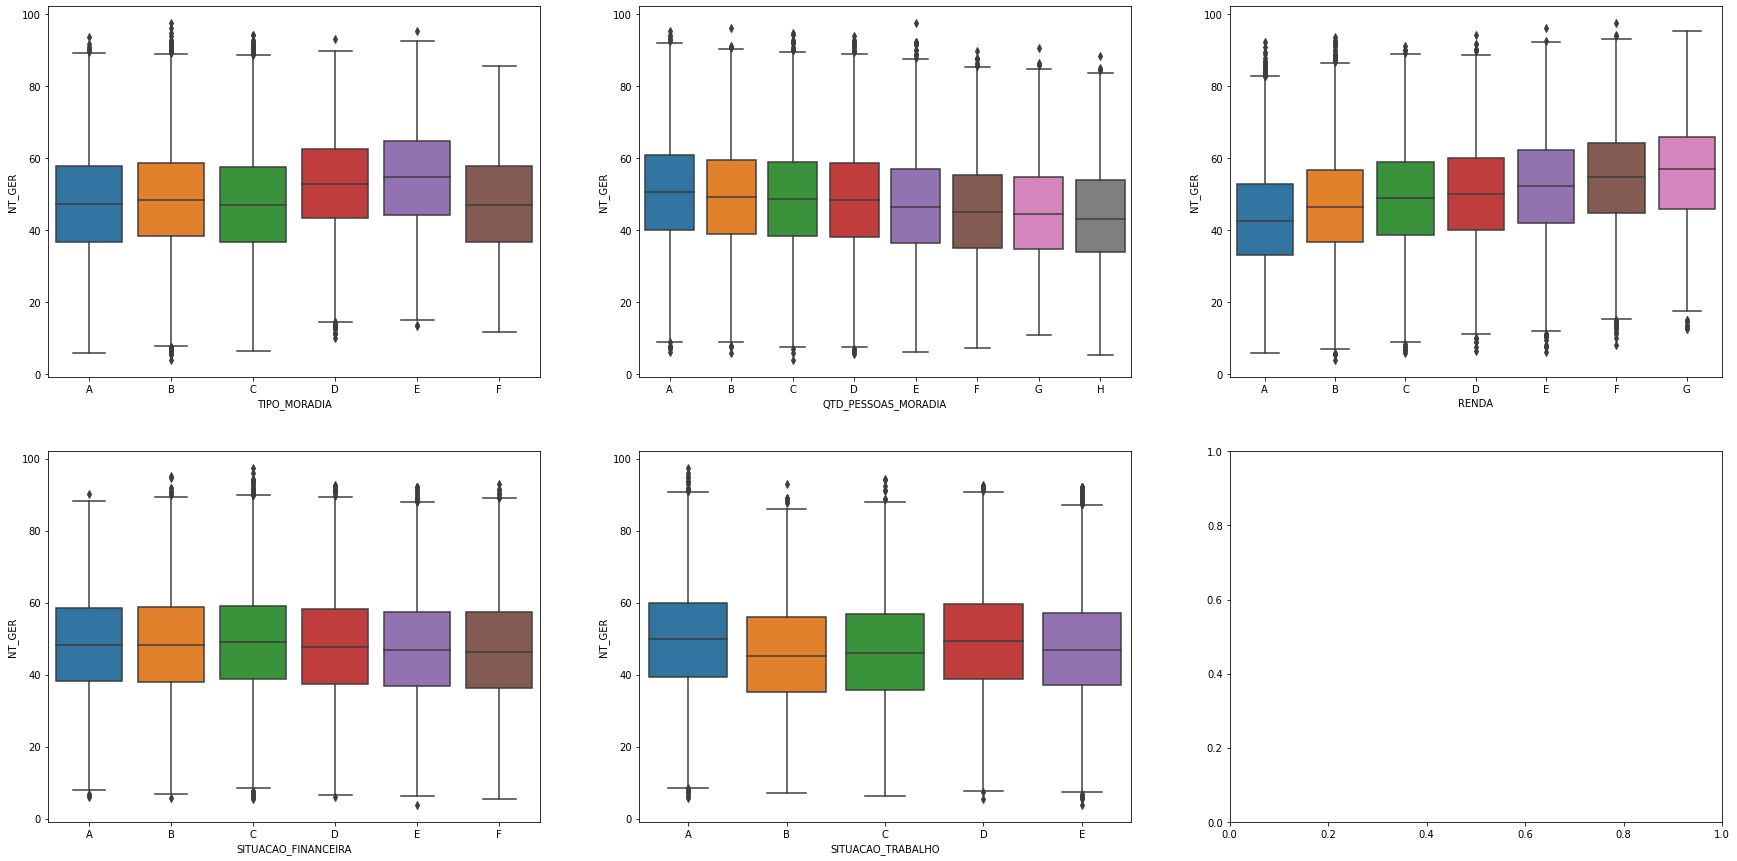

In [80]:
###Distribuição das notas
f, axs = plt.subplots(2,3,figsize=(30,15))
plt.subplot(231)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.TIPO_MORADIA, order = ['A','B','C','D','E', 'F'])
plt.subplot(232)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.QTD_PESSOAS_MORADIA, order = ['A','B','C','D','E', 'F', 'G', 'H'])
plt.subplot(233)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.RENDA, order = ['A','B','C','D','E', 'F','G'])
plt.subplot(234)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.SITUACAO_FINANCEIRA, order = ['A','B','C','D','E', 'F'])
plt.subplot(235)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.SITUACAO_TRABALHO, order = ['A','B','C','D','E'])
plt.show()

In [81]:
#Agrupar tipo de moradia em Repubica e Outros
data_filtrada.TIPO_MORADIA = np.where(data_filtrada.TIPO_MORADIA == 'D', 'Republica', data_filtrada.TIPO_MORADIA)
data_filtrada.TIPO_MORADIA = np.where(data_filtrada.TIPO_MORADIA == 'E', 'Republica', 'Outros')

In [82]:
#Passar variavel qtd pessoas moradia para numerica
data_filtrada.QTD_PESSOAS_MORADIA = data_filtrada.QTD_PESSOAS_MORADIA.replace({'A':0,
'B':1,
'C':2,
'D':3,
'E':4,
'F':5,
'G':6,
'H':7})

In [83]:
#Deixar variavel Renda como ordinal
data_filtrada.RENDA = data_filtrada.RENDA.replace({'A':0,
'B':1,
'C':2,
'D':3,
'E':4,
'F':5,
'G':6})

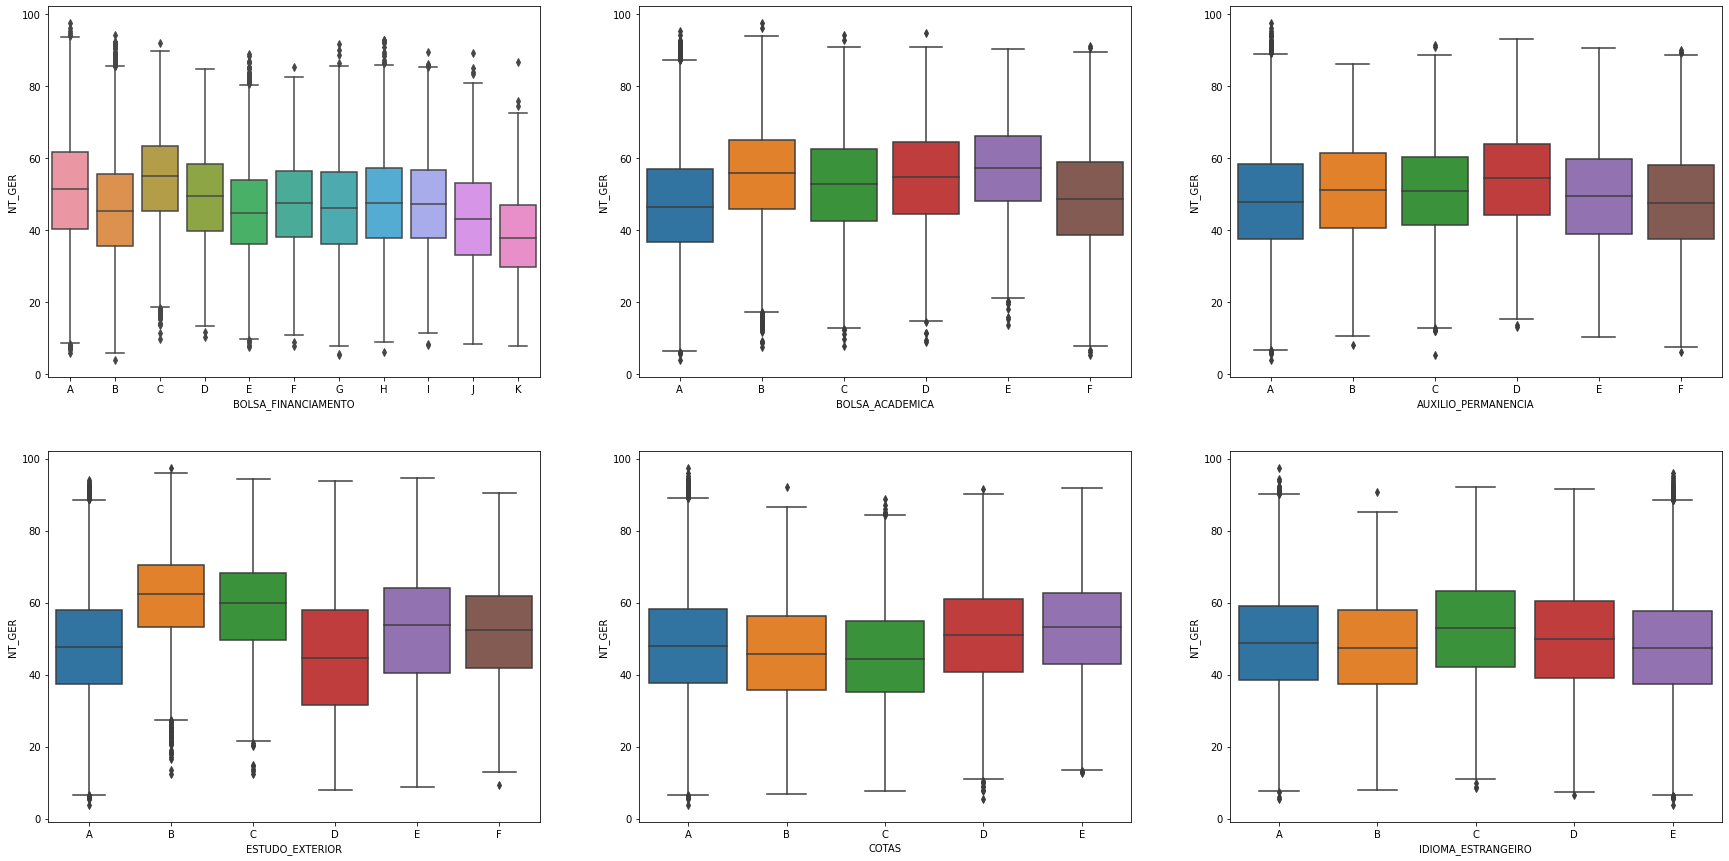

In [84]:
###Distribuição das notas
f, axs = plt.subplots(2,3,figsize=(30,15))
plt.subplot(231)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.BOLSA_FINANCIAMENTO, order = ['A','B','C','D','E', 'F','G', 'H','I','J','K'])
plt.subplot(232)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.BOLSA_ACADEMICA, order = ['A','B','C','D','E', 'F' ])
plt.subplot(233)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.AUXILIO_PERMANENCIA, order = ['A','B','C','D','E', 'F'])
plt.subplot(234)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.ESTUDO_EXTERIOR, order = ['A','B','C','D','E', 'F'])
plt.subplot(235)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.COTAS, order = ['A','B','C','D','E'])
plt.subplot(236)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.IDIOMA_ESTRANGEIRO, order = ['A','B','C','D','E'])
plt.show()

In [85]:
#Agrupar Bolsa ou Financiamento
data_filtrada.BOLSA_FINANCIAMENTO = np.where(data_filtrada.BOLSA_FINANCIAMENTO == 'C', 'PROUNI', data_filtrada.BOLSA_FINANCIAMENTO)
data_filtrada.BOLSA_FINANCIAMENTO = np.where(data_filtrada.BOLSA_FINANCIAMENTO == 'D', 'PROUNI', data_filtrada.BOLSA_FINANCIAMENTO)
data_filtrada.BOLSA_FINANCIAMENTO = np.where(data_filtrada.BOLSA_FINANCIAMENTO == 'H', 'Bolsa', data_filtrada.BOLSA_FINANCIAMENTO)
data_filtrada.BOLSA_FINANCIAMENTO = np.where(data_filtrada.BOLSA_FINANCIAMENTO == 'I', 'Bolsa', data_filtrada.BOLSA_FINANCIAMENTO)
data_filtrada.BOLSA_FINANCIAMENTO = np.where(data_filtrada.BOLSA_FINANCIAMENTO == 'G', 'Bolsa', data_filtrada.BOLSA_FINANCIAMENTO)
data_filtrada.BOLSA_FINANCIAMENTO = np.where(data_filtrada.BOLSA_FINANCIAMENTO == 'J', 'Financiamento', data_filtrada.BOLSA_FINANCIAMENTO)
data_filtrada.BOLSA_FINANCIAMENTO = np.where(data_filtrada.BOLSA_FINANCIAMENTO == 'K', 'Financiamento', data_filtrada.BOLSA_FINANCIAMENTO)

In [86]:
#Agrupar Bolsa Academica
data_filtrada.BOLSA_ACADEMICA = np.where(data_filtrada.BOLSA_ACADEMICA == 'B', 'Bolsa Tradicional', data_filtrada.BOLSA_ACADEMICA)
data_filtrada.BOLSA_ACADEMICA = np.where(data_filtrada.BOLSA_ACADEMICA == 'C', 'Bolsa Tradicional', data_filtrada.BOLSA_ACADEMICA)
data_filtrada.BOLSA_ACADEMICA = np.where(data_filtrada.BOLSA_ACADEMICA == 'D', 'Bolsa Tradicional', data_filtrada.BOLSA_ACADEMICA)
data_filtrada.BOLSA_ACADEMICA = np.where(data_filtrada.BOLSA_ACADEMICA == 'E', 'Bolsa Tradicional', data_filtrada.BOLSA_ACADEMICA)

In [87]:
#Agrupar Auxilio Permanencia
data_filtrada.AUXILIO_PERMANENCIA = np.where(data_filtrada.AUXILIO_PERMANENCIA == 'B', 'Moradia e ou Alimentacao', data_filtrada.AUXILIO_PERMANENCIA)
data_filtrada.AUXILIO_PERMANENCIA = np.where(data_filtrada.AUXILIO_PERMANENCIA == 'C', 'Moradia e ou Alimentacao', data_filtrada.AUXILIO_PERMANENCIA)
data_filtrada.AUXILIO_PERMANENCIA = np.where(data_filtrada.AUXILIO_PERMANENCIA == 'D', 'Moradia e ou Alimentacao', data_filtrada.AUXILIO_PERMANENCIA)
data_filtrada.AUXILIO_PERMANENCIA = np.where(data_filtrada.AUXILIO_PERMANENCIA == 'E', 'Moradia e ou Alimentacao', data_filtrada.AUXILIO_PERMANENCIA)
data_filtrada.AUXILIO_PERMANENCIA = np.where(data_filtrada.AUXILIO_PERMANENCIA == 'A', 'Nenhum ou Outros', data_filtrada.AUXILIO_PERMANENCIA)
data_filtrada.AUXILIO_PERMANENCIA = np.where(data_filtrada.AUXILIO_PERMANENCIA == 'F', 'Nenhum ou Outros', data_filtrada.AUXILIO_PERMANENCIA)

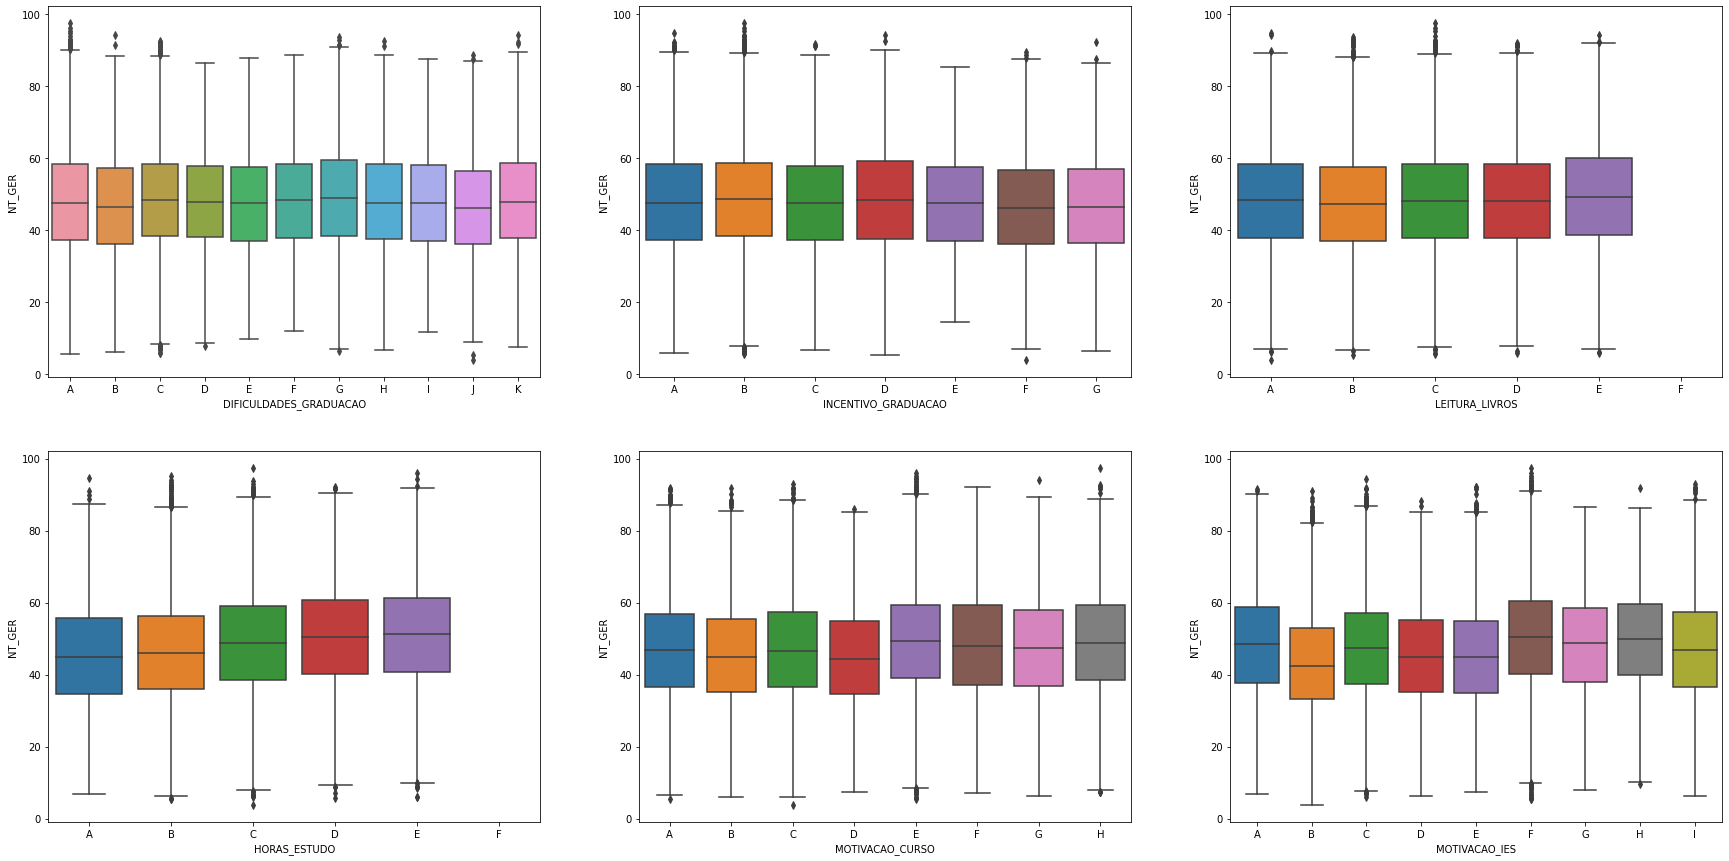

In [88]:
###Distribuição das notas
f, axs = plt.subplots(2,3,figsize=(30,15))
plt.subplot(231)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.DIFICULDADES_GRADUACAO, order = ['A','B','C','D','E', 'F','G', 'H','I','J','K'])
plt.subplot(232)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.INCENTIVO_GRADUACAO, order = ['A','B','C','D','E', 'F','G' ])
plt.subplot(233)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.LEITURA_LIVROS, order = ['A','B','C','D','E', 'F'])
plt.subplot(234)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.HORAS_ESTUDO, order = ['A','B','C','D','E', 'F'])
plt.subplot(235)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.MOTIVACAO_CURSO, order = ['A','B','C','D','E','F','G', 'H'])
plt.subplot(236)
sns.boxplot(y = data_filtrada.NT_GER, x = data_filtrada.MOTIVACAO_IES, order = ['A','B','C','D','E','F','G', 'H','I'])
plt.show()

In [89]:
#Deixar Horas Estudo como ordinal
data_filtrada.HORAS_ESTUDO = data_filtrada.HORAS_ESTUDO.replace({'A':0,
'B':1,
'C':2,
'D':3,
'E':4
})

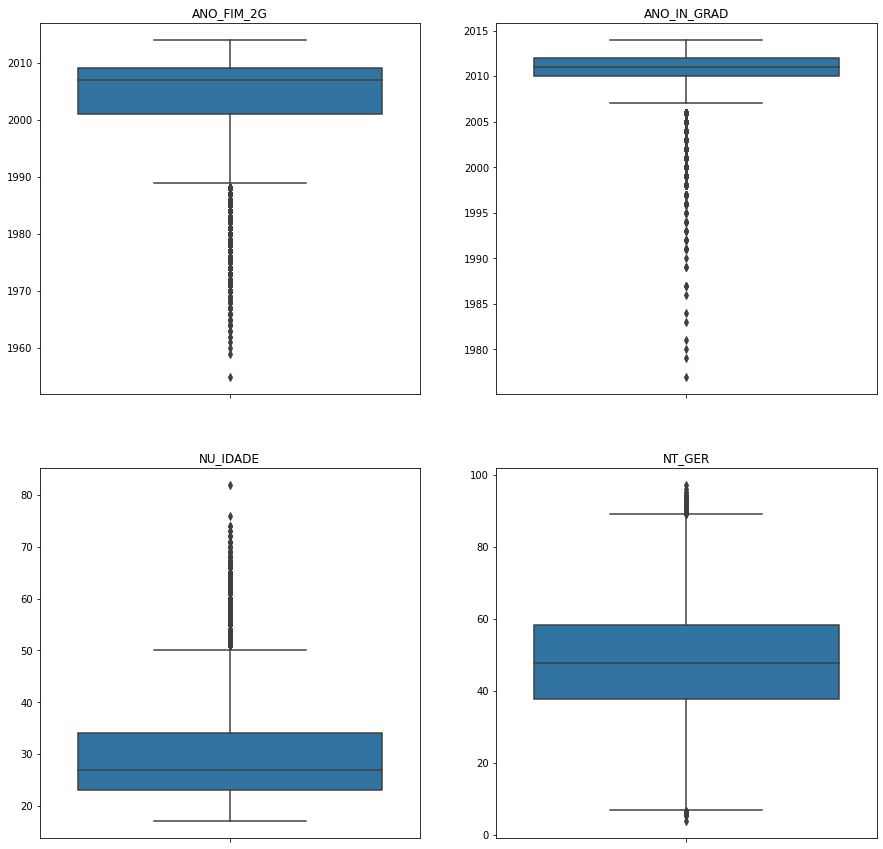

In [90]:
###Distribuição das notas em variaveis numericas
f, axs = plt.subplots(2,2,figsize=(15,15))
plt.subplot(221)
sns.boxplot(y=data_filtrada[['ANO_FIM_2G']])
plt.title('ANO_FIM_2G')
plt.subplot(222)
sns.boxplot(y=data_filtrada[['ANO_IN_GRAD']])
plt.title('ANO_IN_GRAD')
plt.subplot(223)
sns.boxplot(y=data_filtrada[['NU_IDADE']])
plt.title('NU_IDADE')
plt.subplot(224)
sns.boxplot(y=data_filtrada[['NT_GER']])
plt.title('NT_GER')
plt.show()

Text(0.5, 1.0, 'HISTOGRAMA ANO_IN_GRAD > 2004')

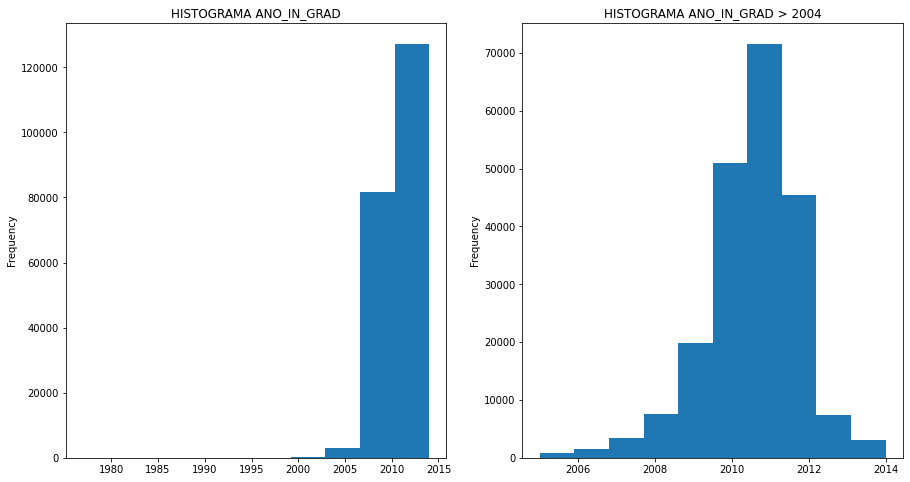

In [92]:
###Distribuição das variaveis numericas
f, axs = plt.subplots(1,2,figsize=(15,8))
plt.subplot(121)
data_filtrada.ANO_IN_GRAD.plot(kind = 'hist')
plt.title('HISTOGRAMA ANO_IN_GRAD')
plt.subplot(122)
data_filtrada.loc[data_filtrada.ANO_IN_GRAD > 2004].ANO_IN_GRAD.plot(kind = 'hist')
plt.title('HISTOGRAMA ANO_IN_GRAD > 2004')

In [93]:
#corrigir tipo de dados
data_filtrada = data_filtrada.astype({'CO_CATEGAD':'object',  
'CO_ORGACAD':'object',
'CO_GRUPO':'object',
'CO_MODALIDADE':'object',
'CO_UF_CURSO':'object',
'CO_REGIAO_CURSO':'object',
'IN_MATUT':'bool',
'IN_VESPER':'bool',
'IN_NOTURNO':'bool',
'ESTADO_ENSINO_MEDIO':'object'})

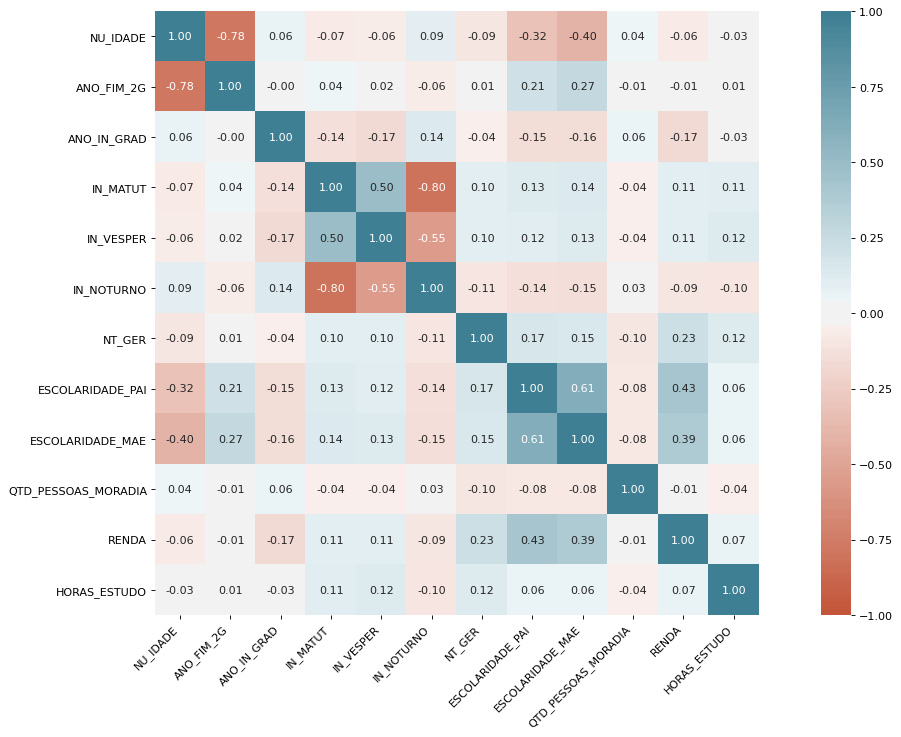

In [94]:
#Matriz de Correlação
corr = data_filtrada.corr()
plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True,
    fmt = '.2f'
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# Rodar modelos

In [96]:
features = [ 'CO_CATEGAD', 'CO_ORGACAD', 'CO_GRUPO', 
        'NU_IDADE',
        'ANO_FIM_2G', 'ANO_IN_GRAD', 'IN_MATUT', 'IN_VESPER',
       'IN_NOTURNO', 'ESTADO_CIVIL',
       'NACIONALIDADE', 'ESCOLARIDADE_PAI', 'ESCOLARIDADE_MAE', 'TIPO_MORADIA',
       'QTD_PESSOAS_MORADIA', 'RENDA', 
       'SITUACAO_TRABALHO', 'BOLSA_FINANCIAMENTO', 'AUXILIO_PERMANENCIA',
       'BOLSA_ACADEMICA', 'ESTUDO_EXTERIOR', 'COTAS', 
       'ESTADO_ENSINO_MEDIO',
       'TIPO_ESCOLA_ENSINO_MEDIO', 'MODALIDADE_ENSINO_MEDIO',       
       'FAMILIAR_COM_CURSO_SUPERIOR', 'HORAS_ESTUDO'
       ]

In [97]:
X = data_filtrada[features]
y = data_filtrada['NT_GER']

X1 = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=10)

In [98]:
#Normalizar
scaler = StandardScaler()
scaler.fit(X_train)

X_test = scaler.transform(X_test)
X_train = scaler.transform(X_train)
X_test = pd.DataFrame(X_test, columns = X1.columns)
X_train = pd.DataFrame(X_train, columns = X1.columns)

# SVR

In [100]:
from sklearn.svm import LinearSVR

In [104]:
regressor = LinearSVR(random_state = 10)
regressor.fit(X_train, y_train)

LinearSVR(random_state=10)

In [108]:
print(f'RMSE:{rmse(y_test, regressor.predict(X_test))}')

RMSE:12.522105426419982


# Regressão Linear

In [109]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [110]:
clf_lr = lr.fit(X_train, y_train)

In [111]:
print(f'RMSE:{rmse(y_test, lr.predict(X_test))}')

RMSE:12.503229839084787


# Random Forest

In [112]:
rf = RandomForestRegressor()

In [118]:
tuned_parameters_rf = [{'bootstrap': [True],
 'max_depth': [5,10],
 'max_features': ['auto'],
 'min_samples_split': [5,10,20],
 'n_estimators': [100,200],
 'random_state':[32]}]

In [119]:
clf_rf = GridSearchCV(rf, 
                      tuned_parameters_rf,
                      cv=2,
                      scoring='neg_root_mean_squared_error')
clf_rf.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
print(f'RMSE:{rmse(y_test, clf_rf.predict(X_test))}')

# XGBoost

In [122]:
import xgboost as xgb

In [123]:
XGB_model = xgb.XGBRegressor(random_state = 32)

params=[{
    'max_depth': [4], 
    'subsample': [1], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'colsample_bytree': [0.6], #[0.5,0.6,0.7,0.8],
    'n_estimators': [900], #[1000,2000,3000]
    'reg_alpha': [0.03] #[0.01, 0.02, 0.03, 0.04]
}]

In [126]:
xgb_clf = GridSearchCV(XGB_model,
                  params,
                  cv=2,
                  scoring="neg_root_mean_squared_error",
                  n_jobs=4,
                  verbose=0)
xgb_clf.fit(X_train, y_train)
print(f'RMSE:{rmse(y_test, xgb_clf.predict(X_test))}')

RMSE:12.23091154132732


# Feature Importance com XGB

In [129]:
from xgboost import plot_importance

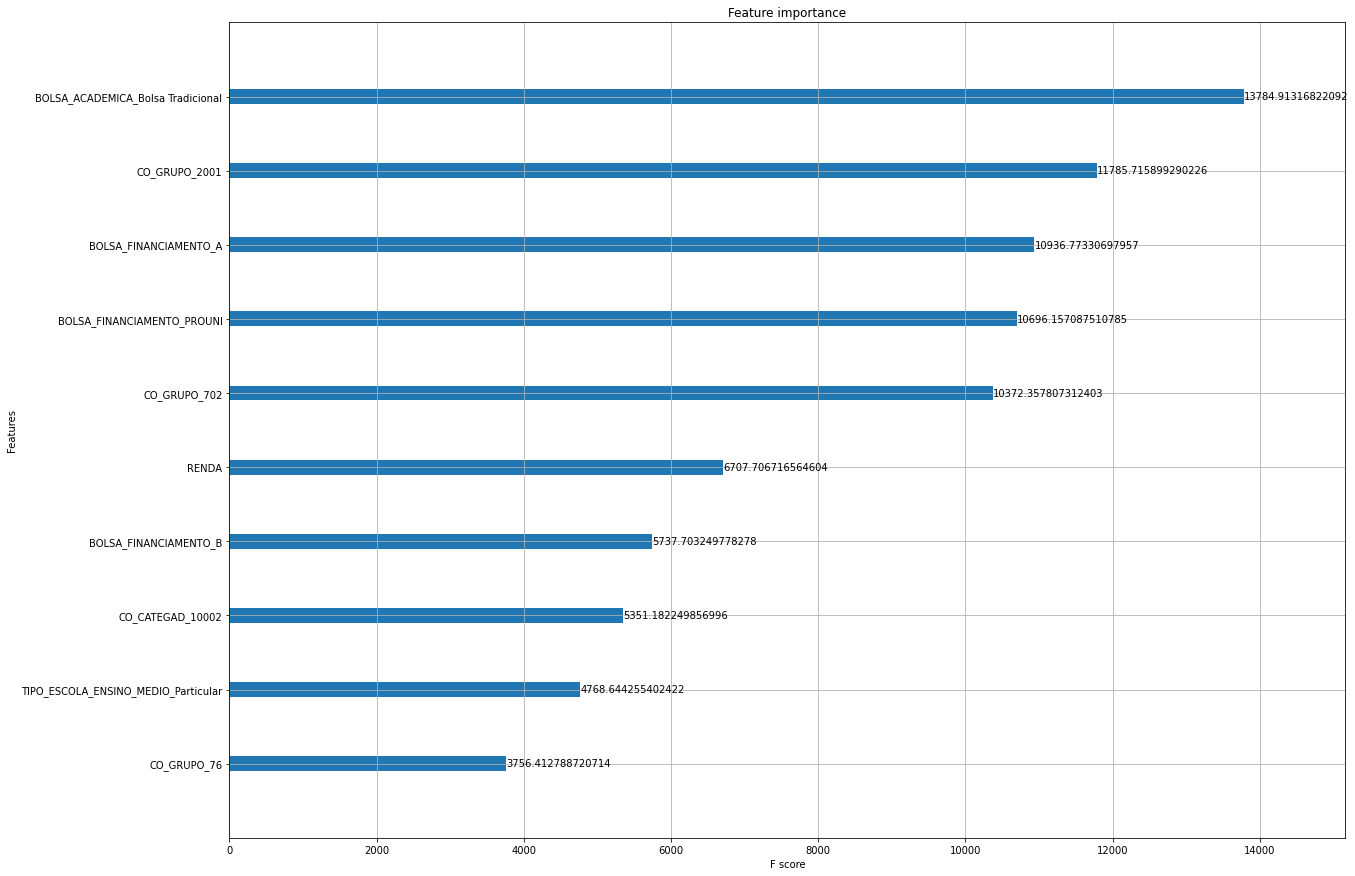

In [130]:
f, axs = plt.subplots(figsize=(20,15))
plot_importance(xgb_clf.best_estimator_, importance_type='gain', max_num_features=10, ax = axs )

## LightGBM

In [138]:
import lightgbm as lgb

In [139]:
d_train = lgb.Dataset(X_train, label=y_train)

In [140]:
LGB_model = lgb.LGBMRegressor(random_state = 32)

In [141]:
params = {}
params['learning_rate'] = [0.1]
params['boosting_type'] = ['gbdt']
params['objective'] = ['regression']
params['metric'] = ['mse']
#params['sub_feature'] = 0.5
params['num_leaves'] = [100]
params['min_data'] = [10,20,50]
#params['max_depth'] = 10

In [142]:
lgb_clf = GridSearchCV(LGB_model,
                  params,
                  cv=2,
                  scoring="neg_root_mean_squared_error",
                  n_jobs=4,
                  verbose=0)
lgb_clf.fit(X_train, y_train)
print(f'RMSE:{rmse(y_test, lgb_clf.predict(X_test))}')

RMSE:12.225257294731602


## Redes Neurais

In [143]:
from sklearn.neural_network import MLPRegressor

In [144]:
tuned_parameters = [{'hidden_layer_sizes': [ (10,10)],
                     'activation' : ['relu']
                     }]


In [145]:
mlp_clf = GridSearchCV(MLPRegressor(random_state=32,max_iter=3000),
                       tuned_parameters,
                       cv=2,
                       scoring='neg_root_mean_squared_error')
mlp_clf.fit(X_train, y_train)
print(f'RMSE:{rmse(y_test, mlp_clf.predict(X_test))}')

RMSE:12.385218835882446
